# Подготовка данных для обучения

In [66]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import re

from tqdm.notebook import tqdm

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('twitter_samples')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import twitter_samples
import gensim


from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.spatial.distance import euclidean, cosine
from scipy.spatial.distance import cdist
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

### Данные

Для ускорения исследования, скачаем весь датасет, и будем собирать батчи из него.

In [67]:
df = pd.read_csv('twitter_dataset_4_9000_2000.csv', low_memory=False)
df.dropna(inplace=True)

In [68]:
df.shape

(14999, 5)

In [69]:
def stream_generator(batch_size=10):
    
    # df = pd.read_csv('twitter_dataset.csv')
    for i in range(0, df.shape[0], batch_size):
        stream_batch = df.iloc[i : min(i + batch_size, df.shape[0])]
        yield stream_batch['content'].tolist(), stream_batch['novel'].tolist()

In [70]:
for batch in stream_generator():
    print(batch)
    break

(['Tune in 11:30 ET tomorrow for a live webcast of Families USA Presidential Forum on health care: http://presidentialforums.health08.org/', 'PHOTOS: Tour with Sen. Mark Udall of Ascent Solar Technologies in Thornton. http://tinyurl.com/ko4egc', 'Michael was out early on Sunday giving doughnuts to participants in the Denver PrideFest Parade: http://tinyurl.com/lm876m. PHOTOS.', 'BLOG: Michael was recently interviewed about education. He urged the system must be adapted to meet 21st century needs. http://bit.ly/1avORn', 'BLOG: Bennet votes against $1.75 billion in government waste; supports elimination of more spending on F-22. Read more: http://bit.ly/b9B7Z', "Thanks for the support @kaffeinebuzz.  I'm committed to responsible reforms that will lower cost and increase coverage for Coloradans.", 'PHOTOS: Michael attended the annual summer picnic hosted by the Democratic Party of Denver on Sunday, August 2. http://bit.ly/4zueoq', "LINK: Dealers applaud 'Clunkers' extension, The Coloradoa

### Предобработка

Будем удалять по возможности все теги(@) и ссылки. Некоторые стоп-слова также удалим. Применим в одном варианте лемматизацию, в другом - стемминг.

In [71]:
class Preprocessor:
    
    def __init__(self):
        self.methods = {
            'lemm' : self.lemmatization,
            'stem' : self.stemming
        }
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.swords = set( stopwords.words("english") )
     
    def preprocess1(self, content_batch, standard='lemm'):
        # stream_batch = ([content], [novel]), content = list(string), novel = list
    
        preprocessed_batch = []
        for doc in content_batch:
            doc = doc.lower()
            doc = self.delete_tags(doc)
            doc = self.delete_links(doc)
            doc = self.delete_garbage(doc)
            tokens = self.get_tokens(doc)
            tokens = self.methods[standard](tokens)
            tokens = self.delete_stop_words(tokens)
            preprocessed_batch.append( ' '.join(tokens) )
            
        return preprocessed_batch
    
    
    def delete_tags(self, doc):
        doc = re.sub(r'^@[\w]*', ' ', doc) 
        doc = re.sub(r'\s@[\w]*', ' ', doc)
        return doc
    
    
    def delete_links(self, doc):
        doc = re.sub(r'http\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'https\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'ftp\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'www\.[\w\-&\./?=\+;@#%]*', ' ', doc)
        return doc
    
    
    def delete_garbage(self, doc):
        doc = re.sub(r'\s+', ' ', doc)
        doc = re.sub(r"[^a-zA-Z0-9\s\']*", '', doc) # TODO: посмотреть что оставляет CountVectorizer
        return doc
    
    
    def delete_stop_words(self, tokens): # TODO: create own sw list
        # new_tokens = []
        return list( filter(lambda sword: sword not in self.swords, tokens) )
#         for sword in swords:
#             if sword not in stop_words:
#                 new_tokens.append(sword)
#         return new_tokens
    
    
    def get_tokens(self, doc):
        return list(map(lambda token: token.lower(), doc.split()))
    
    
    def lemmatization(self, tokens):
        return list(map(lambda token: self.lemmatizer.lemmatize(token), tokens))
    
    
    def stemming(self, tokens):
        return list( map(lambda token: self.stemmer.stem(token), tokens) )

### Векторизация

Скачаем твиттер-корпус, и создадим из него фиксированный словарь для векторизации.

In [72]:
def create_vocab():
    twitter_samples.fileids()
    vocab_corpus = ([(t, "pos") for t in twitter_samples.strings("positive_tweets.json")] + 
             [(t, "neg") for t in twitter_samples.strings("negative_tweets.json")] +
             [(t, "neg") for t in twitter_samples.strings("tweets.20150430-223406.json")]
            )
    vocab_corpus = list( map( lambda pair: pair[0], vocab_corpus ) )
    return vocab_corpus

In [73]:
vocab_corpus = create_vocab()

In [74]:
print( len(vocab_corpus) )
print( vocab_corpus[0] )

30000
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


Класс, в котором будут реализованы основные методы векторизации.

In [75]:
class Vectorizer():
    
    def __init__(self, method, train_corpus):
        self.methods = {
            'one-hot' : self.one_hot_vectorizer,
            'count' : self.count_vectorizer,
            'tf-idf' : self.tfidf_vectorizer,
            #'n-gramms' : self.n_gramms_vectorizer,
            'doc-to-vec' : self.doc_to_vec_vectorizer
        }
        if method not in self.methods:
            raise Exception('Wrong method: {}'.format(method))
        
        self.method = method
        self.model = None
        self.train_corpus = Preprocessor().preprocess1( train_corpus )
        
    
    def vectorize(self, batch, **args):
        return self.methods[self.method](batch, **args)
        
    
    def one_hot_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = CountVectorizer(binary=True, **args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
    
    
    def count_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = CountVectorizer(**args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
    
    
    def tfidf_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = TfidfVectorizer(**args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
        
        
    def doc_to_vec_vectorizer(self, batch, **args):
        
        def extract_tokens(train = False):
            if train:
                for i, doc in enumerate(self.train_corpus):
                    tokens = Preprocessor().get_tokens(doc)
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])    
                    
            else:
                for i, doc in enumerate(batch):
                    tokens = Preprocessor().get_tokens(doc)
                    yield tokens

        
        if self.model is None:
            # vocab = list( extract_tokens(train=True) )
            vocab = list( extract_tokens(train=True) )
            self.model = gensim.models.doc2vec.Doc2Vec(min_count=1, vector_size=20)
            # self.model.build_vocab(train_corpus, update = True)
            # self.model.build_vocab(self.train_corpus)
            self.model.build_vocab( vocab )
            self.model.train(vocab, total_examples=self.model.corpus_count, epochs=5, **args)
        
        return np.array( list( map( lambda token: self.model.infer_vector(token), extract_tokens() ) ) )

### Визуализируем на плоскости

In [76]:
v1 = Vectorizer('tf-idf', vocab_corpus)

In [77]:
n_iter = 1000
n_jobs = 4

In [78]:
X = df['content'].tolist()
X = pp.preprocess1(X)
X = v1.vectorize(X)
Xe = TSNE(n_components=2, n_iter=n_iter, n_jobs=n_jobs, verbose=1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14999 samples in 0.001s...
[t-SNE] Computed neighbors for 14999 samples in 31.460s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14999
[t-SNE] Computed conditional probabilities for sample 2000 / 14999
[t-SNE] Computed conditional probabilities for sample 3000 / 14999
[t-SNE] Computed conditional probabilities for sample 4000 / 14999
[t-SNE] Computed conditional probabilities for sample 5000 / 14999
[t-SNE] Computed conditional probabilities for sample 6000 / 14999
[t-SNE] Computed conditional probabilities for sample 7000 / 14999
[t-SNE] Computed conditional probabilities for sample 8000 / 14999
[t-SNE] Computed conditional probabilities for sample 9000 / 14999
[t-SNE] Computed conditional probabilities for sample 10000 / 14999
[t-SNE] Computed conditional probabilities for sample 11000 / 14999
[t-SNE] Computed conditional probabilities for sample 12000 / 14999
[t-SNE] Computed conditional probabilities for sa

In [79]:
mask1 = (df['type'] == 1).astype(dtype=int).to_numpy()
mask2 = (df['type'] == 2).astype(dtype=int).to_numpy()
mask3 = (df['type'] == 3).astype(dtype=int).to_numpy()
mask4 = (df['type'] == 4).astype(dtype=int).to_numpy()

In [80]:
X1 = Xe[np.where(mask1)]
X2 = Xe[np.where(mask2)]
X3 = Xe[np.where(mask3)]
X4 = Xe[np.where(mask4)]

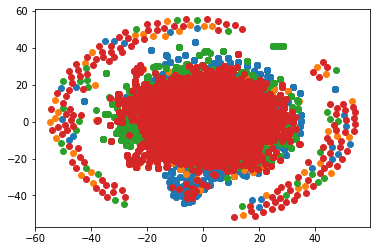

In [81]:
plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X3[:, 0], X3[:, 1])
plt.scatter(X4[:, 0], X4[:, 1])

В данной визуалиции кластеры разных тем никак не отделены друг от друга. Посмотрим, как с этим справятся алгоритмы.

### KNN

В качестве обратной меры новизны будем использовать отношение средней плотности k ближайших к объекту соседей и локальной плотности самого объекта. Если это отношение будет достаточно близко к нулю, то можно воспринимать объект как аномальный.

Локальную плотность считаем так - находим минимальный радиус сферы, внутри которой находятся k ближайших соседей для данного объекта(считая сам объект).

Но нет, лучше зафиксируем k, и будем смотреть r

Pipeline:

- Считываем достаточное количество примеров из потока для обучения: n_start = 200. 
- Далее считываем по батчу данных размера n_batch
- Для каждого объекта в батче считаем локальную плотность, и заодно ищем индексы k_nbr = 5 ближайших соседей 
- Для каждого из k_nbr ближайших соседей считаем локальную плотность
- Усредняем, делим, получаем обратную меру новизны
- Сравниваем с порогом(который сначала нужно подобрать)
- В конце обработки элемента добавляем его в известную выборку

ро = k / r^dim

In [82]:
class Knn(BaseEstimator):
    
    def __init__(self, n_start=100, n_neighbors=5, max_samples = 5000,
                 default_normal_score=1, eps=0.5683, algorithm='kd_tree', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric 
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = default_normal_score
        self.threshold = eps
        
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype) 
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count]
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
        
        for x in X[start_count: ]:
            score = self.get_novel_score(x)
            if self.pos >= self.data.shape[0]:
                self.data = np.append(self.data, [x], axis=0)
            self.pos = (self.pos + 1) % self.max_samples
            yield score
    
    
    
    def get_novel_score(self, obj): # normal score

        dist, ind = self.get_neighbors([obj])
        int_lof = dist[0, -1] # radius of sphere
        
        dist, ind = self.get_neighbors( [self.data[i] for i in ind[0]] )
        ext_lof = np.mean( dist[:, -1] )
        
        return (1 + ext_lof) / (1 + int_lof)
    
    
    def get_neighbors(self, X):
        
        X = np.asarray(X)
        
        if self.algorithm == 'kd_tree':

            tree = KDTree(self.data)
            dist, ind = tree.query(X, k=self.n_neighbors)
            return dist, ind

        else:
            raise Exception('unknown algorithm')

In [83]:
def run_alg(pp, alg, svd_compenents, n_iter, batch_size, vectorization, eps):

    svd = TruncatedSVD(n_components=svd_compenents, n_iter=n_iter, random_state=42)
    scores = []

    answers = []
    targets = []

    for batch, target in tqdm( stream_generator(batch_size) ):
        batch = pp.preprocess1(batch)
        v1 = Vectorizer(vectorization, vocab_corpus)
        vectors = v1.vectorize(batch)
        if vectorization != 'doc-to-vec':
            vectors = svd.fit_transform(vectors)

        scores.append( list(alg.check_novelty(vectors)) )
        
        answers += [int(score < alg.threshold) for score in scores[-1]]
        targets += target

        scores.append( list(alg.check_novelty(vectors)) )
    
    print( svd_compenents, n_iter, batch_size, vectorization, eps)
    print( accuracy_score(answers, targets) )
    print( f1_score(answers, targets) )
    print( roc_auc_score(answers, targets) )
    print()
    
    return accuracy_score(answers, targets), f1_score(answers, targets), roc_auc_score(answers, targets)

### Подбираем параметры.

Результаты замеров есть в таблице:

https://docs.google.com/spreadsheets/d/1a6M76eS8L-WTGKVI-xRajut2P-X70j-bv5s_7WZv3ZE/edit?usp=sharing

In [ ]:
pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.68888, 0.76666, 0.8444444444444446]:
    try:
        alg = Knn(max_samples=2000, eps=eps)
        acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=5, n_iter=7,
                                   batch_size=300, vectorization='tf-idf', eps=eps)
    except Exception as err:
        print(err)
    m_acc.append(acc)
    m_f1.append(f1)
    m_roc_auc.append(roc_auc)

In [ ]:
pp = Preprocessor()
alg = Knn(max_samples=2000, )

m_acc = []
m_f1 = []
m_roc_auc = []

pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.55, 0.68888, 0.76666, 0.8444444444444446]:
    for batch_size in [2000, 500, 300]:
        for n_iter in [10, 25, 50]:
            try:
                alg = Knn(max_samples=2000, eps=eps)
                acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=5, n_iter=n_iter,
                                           batch_size=batch_size, vectorization='tf-idf', eps=eps)
            except Exception as err:
                print(err)
            m_acc.append(acc)
            m_f1.append(f1)
            m_roc_auc.append(roc_auc)

In [ ]:
pp = Preprocessor()
alg = Knn(max_samples=2000, )

m_acc = []
m_f1 = []
m_roc_auc = []

pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.68888, 0.76666, 0.8444444444444446]:
    for batch_size in [500, 300]:
        for svd_compenents in [3, 10, 20, 30]:
            try:
                alg = Knn(max_samples=2000, eps=eps)
                acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=svd_compenents, n_iter=10,
                                           batch_size=batch_size, vectorization='tf-idf', eps=eps)
            except Exception as err:
                print(err)
            m_acc.append(acc)
            m_f1.append(f1)
            m_roc_auc.append(roc_auc)

In [26]:
pp = Preprocessor()
alg = Knn(max_samples=2000, )

m_acc = []
m_f1 = []
m_roc_auc = []

pp = Preprocessor()

m_acc = []
m_f1 = []
m_roc_auc = []

for eps in [0.68888, 0.76666]:
    for batch_size in [500]:
        for vectorization in ['doc-to-vec']:
            alg = Knn(max_samples=2000, eps=eps)
            acc, f1, roc_auc = run_alg(pp, alg, svd_compenents=20, n_iter=10,
                                           batch_size=batch_size, vectorization=vectorization, eps=eps)
            try:
                pass
            except Exception as err:
                print(err)
            m_acc.append(acc)
            m_f1.append(f1)
            m_roc_auc.append(roc_auc)


20 10 500 doc-to-vec 0.68888
0.979865324354957
0.0
0.48999799959991996



KeyboardInterrupt: 

Есть предположение, что аномалии в нашем датасете не отличимы от нормальных данных. Проверим это, перебрав пороги по всем аномальным твитам и анализируя поведение метрик.

In [29]:
def run_alg_with_scores(pp, alg, n_iter, batch_size, vectorization, eps, svd_compenents=10):

    svd = TruncatedSVD(n_components=svd_compenents, n_iter=n_iter, random_state=42)
    scores = []

    answers = []
    targets = []

    for batch, target in tqdm( stream_generator(batch_size) ):
        batch = pp.preprocess1(batch)
        v1 = Vectorizer(vectorization, vocab_corpus)
        vectors = v1.vectorize(batch)
        if vectorization != 'doc-to-vec':
            vectors = svd.fit_transform(vectors)

        scores.append( list(alg.check_novelty(vectors)) )
        
        answers += [int(score < alg.threshold) for score in scores[-1]]
        targets += target
    
    print( svd_compenents, n_iter, batch_size, vectorization, eps)
    print( accuracy_score(answers, targets) )
    print( f1_score(answers, targets) )
    print( roc_auc_score(answers, targets) )
    print()
    
    return accuracy_score(answers, targets), f1_score(answers, targets), roc_auc_score(answers, targets), scores

In [30]:
acc, f1, roc_auc, scores = run_alg_with_scores(pp, alg, n_iter=10, batch_size=500,
                                               vectorization='doc-to-vec', eps=0.8)


10 10 500 doc-to-vec 0.8
0.9795986399093273
0.0
0.4899953311545388



In [31]:
scores2 = scores.copy()

In [35]:
len(scores)

30

In [37]:
targets = []

for batch, target in tqdm( stream_generator(500) ):
    targets += target

In [57]:
sr = []
for lst in scores:
    sr += lst
sr = np.array(sr).ravel()

tr = np.array(targets).ravel()

In [62]:
eps_list = np.sort(sr[np.where(tr == 1)])

In [64]:
for eps in eps_list:
    answers = np.where(sr < eps, 1.0, 0.0)
    print( accuracy_score(answers, tr) )
    print( f1_score(answers, tr) )
    print( roc_auc_score(answers, tr) )
    print()

0.9781985465697713
0.0
0.4899812984237243

0.9641309420628041
0.003703703703703704
0.4919539207715066

0.9491299419961331
0.0052151238591916565
0.4918880933814528

0.9483965597706514
0.007692307692307692
0.49289702286658865

0.9354623641576105
0.00819672131147541
0.4926255490920178

0.8918594572971531
0.006127450980392158
0.4910844571797963

0.8763917594506301
0.006430868167202571
0.49097250922914437

0.8756583772251484
0.00745077168706759
0.4913000503063211

0.8751916794452963
0.00847457627118644
0.49163230604900254

0.8678578571904794
0.009
0.49170638659253463

0.8643909593972932
0.00973709834469328
0.4919030997691519

0.8599239949329955
0.010362694300518135
0.49205009540443384

0.8591239415961064
0.011230697239120263
0.49232560834596084

0.8559903993599574
0.011893870082342179
0.49250310883640597

0.8531902126808454
0.012556053811659194
0.4926850193690959

0.8520568037869192
0.013339261894175189
0.49292858701485587

0.837989199279952
0.012997562956945572
0.4926385029628955

0.834922

0.49416973866838443

0.38449229948663244
0.029844472467423288
0.49404326333049936

0.3845589705980399
0.03005148681307135
0.49418078770797363

0.38449229948663244
0.030252100840336135
0.4943119657943207

0.38449229948663244
0.030455786599453895
0.4944463677802782

0.3842922861524102
0.030649732339666214
0.4945713005483245

0.379425295019668
0.03061862112059988
0.4944734064902382

0.37742516167744516
0.03072451733444052
0.49451229463940066

0.3752250150010001
0.030820146861102488
0.49454145383655373

0.37395826388425896
0.030959752321981424
0.494615853002107

0.3727581838789253
0.03110195674562307
0.4946936245079858

0.3716914460964064
0.03125
0.4947780215548928

0.3710247349823322
0.03141683778234086
0.49488201107686114

0.35802386825788385
0.030995270202274328
0.4943757153798901

0.3578238549236616
0.031180848923757786
0.49450405727199115

0.3546903126875125
0.03122810529476529
0.49448427393653027

0.35215681045403024
0.03130296082145349
0.494494489075805

0.34055603706913795
0.030959

0.4912360864645381

0.03686912460830722
0.038471778487752926
0.489813909263787

0.03613574238282552
0.03857152357518122
0.490755210828848

0.033935595706380425
0.038614649681528654
0.4900259271320548

0.032535502366824454
0.03868830738655184
0.4902603555785275

0.028468564570971397
0.03865945375379338
0.4850373130409962

0.027601840122674845
0.038753048177684046
0.4860741580300513

0.025001666777785186
0.03878007098724859
0.4804782715017078

0.02326821788119208
0.038840047237895296
0.4748172465697774

0.021001400093339555
0.03887943448095301
0.4384859698987086

0.021068071204746984
0.039007788467831664
0.45994725949662857

0.020334688979265284
0.039105414595867125
0.4385434136301266



Видно, что метрики ведут себя одинаково плохо, даже если в качестве порогов брать amonaly score самих аномальных объектов. 

### SVM

In [77]:
%%time
alg = OneClassSVM(gamma=0.001, nu=0.03, verbose=True)

# time = np.array( [50, 100, 200, 300, 500, 1000, 5000] )

batch_size = 100
svd = TruncatedSVD(n_components=10, n_iter=3, random_state=42)
vectors = None

for batch, target in tqdm( stream_generator(batch_size) ):
    batch = pp.preprocess1(batch)
    v1 = Vectorizer(vectorization, vocab_corpus)
    vectors = v1.vectorize(batch)
    vectors = svd.fit_transform(vectors)
    break


CPU times: user 50.7 s, sys: 6.74 s, total: 57.4 s
Wall time: 57.2 s


In [78]:
%%time
t = alg.fit(vectors)

[LibSVM]CPU times: user 2.4 ms, sys: 6.64 ms, total: 9.03 ms
Wall time: 21.4 ms


In [79]:
%%time
t = alg.predict(vectors)

CPU times: user 577 µs, sys: 271 µs, total: 848 µs
Wall time: 777 µs


### Реализуем обертку над SVM.

Будем содержать хранилище размера, не больше заданного размера, и обучать SVM по нему

In [37]:
class SVM(BaseEstimator):
    
    def __init__(self, n_start=100, max_samples = 5000, nu=0.05):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        self.default_normal_score = 1
        self.alg = OneClassSVM(nu=nu)
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
    
    
    def check_novelty(self, X):
        
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
        
        start_count = 0
        
        if not self.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.n_for_start, X.shape[0])
            
            self.data = X[:start_count].copy()
            
            pos = start_count % self.max_samples
            self.initialized = True
            
            for i in range(start_count):
                yield self.default_normal_score
                
        
        self.update_storage(X, start_count)
        self.alg.fit(self.data)
        
        for target in self.alg.predict(X[start_count:]):
            yield target
            
            
    def update_storage(self, X, start_count):
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ].copy()
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos].copy()
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :].copy()
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :].copy()

In [64]:
%%time

batch_size = 500
vectorization = 'tf-idf'
svd = TruncatedSVD(n_components=10, n_iter=5, random_state=42)
v1 = Vectorizer(vectorization, vocab_corpus)
y_true = []
y_pred = []
pp = Preprocessor()

for nu in [0.00001, 0.0001, 0.0005, 0.0015, 0.005, 0.015]:
    alg = SVM(nu=nu)
    
    for batch, target in tqdm( stream_generator(batch_size) ):
        batch = pp.preprocess1(batch)
        vectors = v1.vectorize(batch)
        vectors = svd.fit_transform(vectors)
        y_pred += list( alg.check_novelty(vectors) )
        y_true += target

    y_pred = np.where(np.array(y_pred) == 1, 0, 1).tolist()

    print( accuracy_score(y_true, y_pred) )
    print( f1_score(y_true, y_pred) )
    try:
        print( roc_auc_score(y_true, y_pred) )
    except:
        print('roc auc failed')
    print()


0.36189079271951463
0.04585784069384907
0.560148082636007




0.7886192412827522
0.03822235704535113
0.5052143002925369




0.4558303886925795
0.03878464316558059
0.501409997656681




0.643042869524635
0.037136948116176606
0.49665473274825955




0.47273818254550304
0.03963666391412056
0.5076418804000272




0.594461853012423
0.03770500448241312
0.49785482383533264

CPU times: user 1min 31s, sys: 12.9 s, total: 1min 44s
Wall time: 1min 9s


### На будущее:

идея параллельного обучения и предсказания:
- один процесс работает с потоком данных, берет текущий обученный svm, предсказывает на нем результат
также он проверяет, что в бакете не накопилось bucket_max_size объектов.
- как только накопилось - запускаем второй процесс, который обучает svm на объектах старых + из бакета, мб 
рандомно выкидываем bucket_max_size объектов из нашего хранилища

По факту даже параллельно не надо делать, svm на 5к примерах быстрее обучается, чем мы получаем векторы. Тогда надо просто иметь хранилище данных фиксированного размера, в котором обновлять данные и обучать svm

TODO:
- сделать обертку над OneClassSVM, в котором будет хранилище, дообучение на каждом батче и предикт
- запустить его на текущих данных
- обкачать сайт и сделать новый датасет
- проверить LOF из sklearn

https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor.fit


https://scikit-learn.org/stable/modules/outlier_detection.html

https://towardsdatascience.com/anomaly-detection-with-local-outlier-factor-lof-d91e41df10f2


https://towardsdatascience.com/support-vector-machine-svm-for-anomaly-detection-73a8d676c331

обкачать
http://famouspoetsandpoems.com/poets/william_blake/poems/1192

BERT для извлечения признаков:
https://habr.com/ru/post/487358/

Можно собрать также датасеты с разной тематикой и обучить нейронку находить различия тем. 

Fizzy